Script to build the data pipeline for particle precipitation data sources

Sources currently being analyzed
- DMSP
    - Description: https://hpde.io/SMWG/Observatory/DMSP_5D-3/
    - Data: (beginning with the F16 spacecraft SSJ instrument) https://cdaweb.gsfc.nasa.gov/misc/NotesD.html#DMSP-F16_SSJ_PRECIPITATING-ELECTRONS-IONS
- FAST
    - Description: https://hpde.io/SMWG/Observatory/FAST.html
    - Data: https://cdaweb.gsfc.nasa.gov/misc/NotesF.html#FA_ESA_L2_EES


In [27]:
import numpy as np
import pandas as pd
import os
import datetime


from cdasws import CdasWs, TimeInterval

import xarray as xr
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm


In [20]:
%matplotlib notebook  # or %matplotlib widget

UsageError: unrecognized arguments: # or %matplotlib widget


In [10]:
cdas = CdasWs()

In [11]:
var_names

['ELE_COUNTS_OBS',
 'ELE_COUNTS_BKG',
 'ELE_DIFF_ENERGY_FLUX',
 'ELE_DIFF_ENERGY_FLUX_STD',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ION_COUNTS_OBS',
 'ION_COUNTS_BKG',
 'ION_DIFF_ENERGY_FLUX',
 'ION_DIFF_ENERGY_FLUX_STD',
 'ION_TOTAL_ENERGY_FLUX',
 'ION_TOTAL_ENERGY_FLUX_STD',
 'ION_AVG_ENERGY',
 'ION_AVG_ENERGY_STD',
 'SC_ECI',
 'SC_GEOCENTRIC_LAT',
 'SC_GEOCENTRIC_LON',
 'SC_GEOCENTRIC_R',
 'SC_AACGM_LAT',
 'SC_AACGM_LON',
 'SC_AACGM_LTIME']

### DMSP 

In [13]:
#  PyPI xarray Option:
#    pip install -U xarray cdflib cdasws

# Read in the data
DMSP_dataset = 'DMSP-F16_SSJ_PRECIPITATING-ELECTRONS-IONS'

var_names = cdas.get_variable_names(DMSP_dataset)
print('Variable names:', var_names)
# example_interval = cdas.get_example_time_interval(DMSP_dataset)
# print('Example time interval:', example_interval)

DMSP_var = ['ELE_DIFF_ENERGY_FLUX',
            'ELE_TOTAL_ENERGY_FLUX',
            'ELE_AVG_ENERGY',
            'SC_AACGM_LAT',
            'SC_AACGM_LON',
            'SC_AACGM_LTIME']
DMSP_interval = TimeInterval('2010-03-01T00:00:00Z', '2010-03-01T23:59:00Z')
status, data = cdas.get_data(DMSP_dataset, DMSP_var, DMSP_interval)

if 'spacepy' in str(type(data)):
    #  see https://spacepy.github.io/datamodel.html
    print(DMSP_var[0], '=', data[DMSP_var[0]])
    print(data[DMSP_var[0]].attrs)
else:
    #  see https://github.com/MAVENSDC/cdflib
    print(DMSP_var[0], '=', data.data_vars[DMSP_var[0]].values)
    print(data.data_vars[DMSP_var[0]].attrs)

print(data)
# ...





Variable names: ['ELE_COUNTS_OBS', 'ELE_COUNTS_BKG', 'ELE_DIFF_ENERGY_FLUX', 'ELE_DIFF_ENERGY_FLUX_STD', 'ELE_TOTAL_ENERGY_FLUX', 'ELE_TOTAL_ENERGY_FLUX_STD', 'ELE_AVG_ENERGY', 'ELE_AVG_ENERGY_STD', 'ION_COUNTS_OBS', 'ION_COUNTS_BKG', 'ION_DIFF_ENERGY_FLUX', 'ION_DIFF_ENERGY_FLUX_STD', 'ION_TOTAL_ENERGY_FLUX', 'ION_TOTAL_ENERGY_FLUX_STD', 'ION_AVG_ENERGY', 'ION_AVG_ENERGY_STD', 'SC_ECI', 'SC_GEOCENTRIC_LAT', 'SC_GEOCENTRIC_LON', 'SC_GEOCENTRIC_R', 'SC_AACGM_LAT', 'SC_AACGM_LON', 'SC_AACGM_LTIME']
ELE_DIFF_ENERGY_FLUX = [[      0.         0.         0.   ...       0.         0.         0.  ]
 [      0.         0.         0.   ...       0.         0.         0.  ]
 [      0.         0.         0.   ...       0.         0.         0.  ]
 ...
 [      0.         0.         0.   ...       0.         0.         0.  ]
 [      0.         0.         0.   ...       0.    525363.75 1159769.4 ]
 [      0.         0.         0.   ...       0.         0.         0.  ]]
{'FIELDNAM': 'ELE_DIFF_ENERGY_F

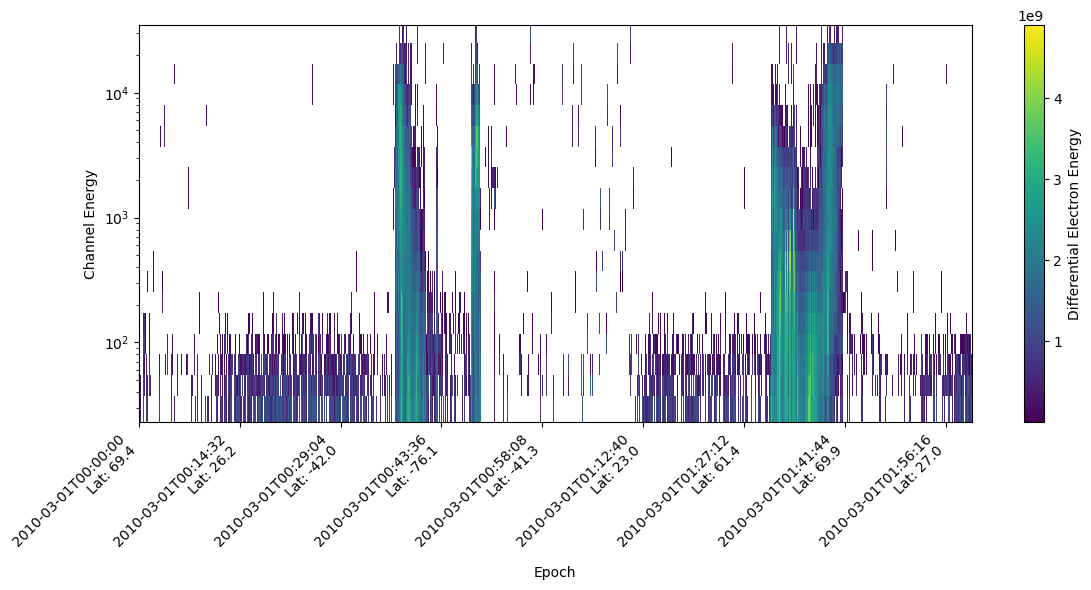

In [30]:
# # Assuming `ds` is your xarray dataset
# ele_diff = data['ELE_DIFF_ENERGY_FLUX']
# epochs = data['Epoch']
# energies = data['CHANNEL_ENERGIES']
# latitudes = data['SC_AACGM_LAT']

# # Mask zeros in the data
# masked_data = np.ma.masked_where((ele_diff.values == 0) | np.isnan(ele_diff.values), ele_diff.values)

# Create a copy of the colormap and set white for bad/masked values
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad(color='white')  # For NaNs and masked (e.g., zeros)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
c = ax.pcolormesh(
    epochs, energies, masked_data.T,
    shading='auto', cmap=cmap
)

# Labeling
ax.set_xlabel('Epoch')
ax.set_ylabel('Channel Energy')
fig.colorbar(c, ax=ax, label='Differential Electron Energy')

# Custom tick labels
xticks = np.linspace(0, len(epochs) - 1, num=min(100, len(epochs)), dtype=int)
xtick_labels = [f"{str(np.datetime_as_string(epochs[i].values, unit='s'))}\nLat: {latitudes[i].values:.1f}" for i in xticks]
ax.set_xticks(epochs[xticks])
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

ax.set_yscale('log')
ax.set_xlim(np.datetime64("2010-03-01T00:00"), np.datetime64("2010-03-01T02:00"))

norm = LogNorm(vmin=masked_data.min(), vmax=masked_data.max())
c = ax.pcolormesh(
    epochs, energies, masked_data.T,
    shading='auto', cmap=cmap, norm=norm
)


plt.tight_layout()
plt.show()

In [ ]:
# Identify the four main types of particle precipitation in the data segment
    # Ryan will code the identification from Newell et al., [2009] https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009JA014326
    # Result will be flags for times when each type of precipitation is present

# (optional) Identify other elements in the phenomena ontology and region taxonomy to label in the data

# Lift the data based on the labels into graph format (construct into graph format)


#### FAST

In [2]:
# FORTHCOMING...

# Read in the data

# Calculate how to identify particle precipitation in FAST data

# (optional) Identify other elements in the phenomena ontology and region taxonomy to label in the data

# Lift the data based on the labels into graph format

